In [11]:
import os
import numpy as np
from PIL import Image

def load_images(image_dir, size=(100, 100)):
    images = []
    filenames = []
    for filename in os.listdir(image_dir):
        if filename.endswith('.JPG'):
            img = Image.open(os.path.join(image_dir, filename)).resize(size).convert('RGB')
            img_array = np.array(img) / 255.0  # Normalize
            images.append(img_array)
            filenames.append(filename)
    return np.array(images), filenames

image_dir = 'clothes_images'
X, filenames = load_images(image_dir)
print(f"Loaded {len(X)} images with shape {X.shape}")

Loaded 36 images with shape (36, 100, 100, 3)


In [13]:
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.models import Model

# Resize for MobileNetV2 (224x224)
X_resized = np.array([np.array(Image.fromarray((img * 255).astype(np.uint8)).resize((224, 224))) for img in X])
X_preprocessed = preprocess_input(X_resized)

base_model = MobileNetV2(include_top=False, pooling='avg', input_shape=(224, 224, 3))
model = Model(inputs=base_model.input, outputs=base_model.output)

features = model.predict(X_preprocessed)
print("Extracted feature shape:", features.shape)

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 368ms/step
Extracted feature shape: (36, 1280)


In [15]:
from sklearn.cluster import KMeans

n_clusters = 8
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
labels = kmeans.fit_predict(features)

/opt/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


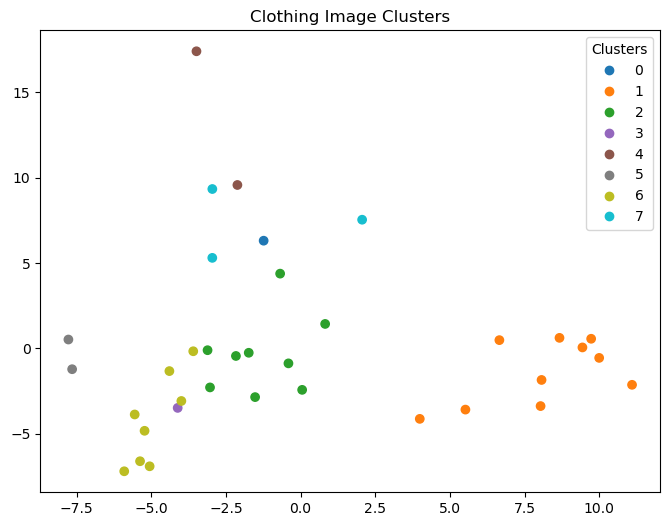

In [17]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

reduced = PCA(n_components=2).fit_transform(features)

plt.figure(figsize=(8, 6))
scatter = plt.scatter(reduced[:, 0], reduced[:, 1], c=labels, cmap='tab10')
plt.legend(*scatter.legend_elements(), title="Clusters")
plt.title("Clothing Image Clusters")
plt.show()

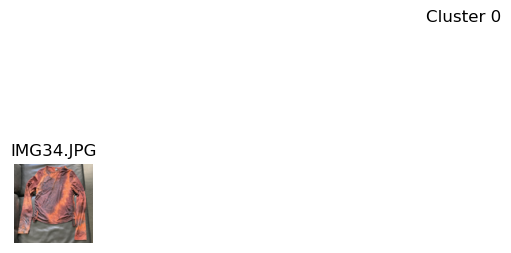

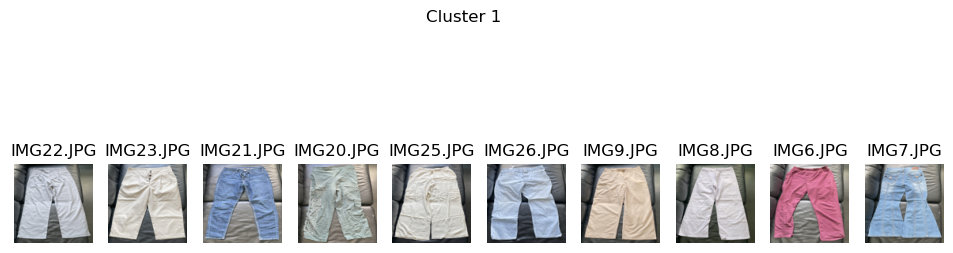

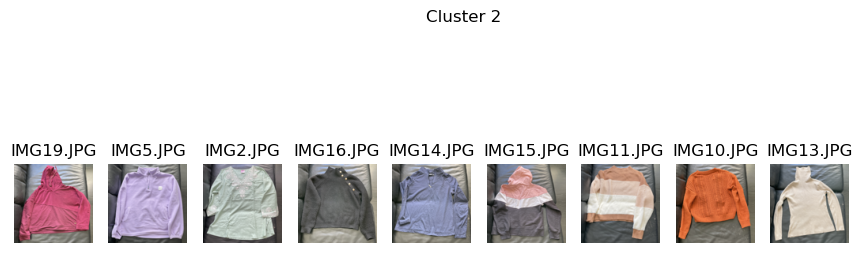

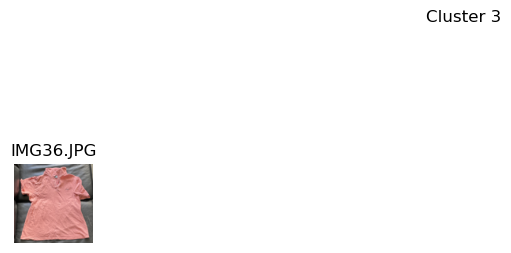

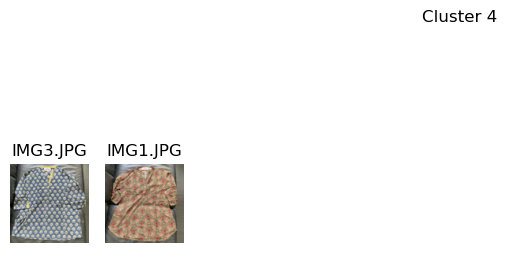

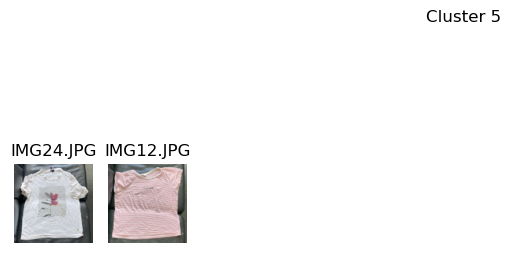

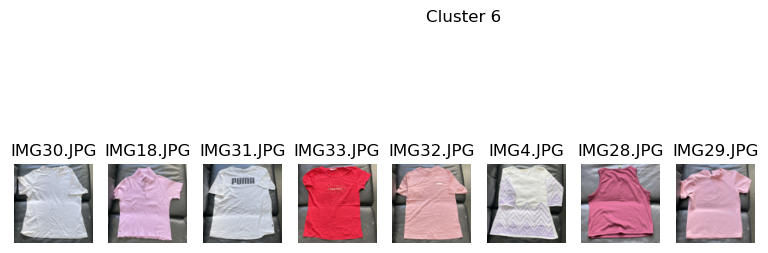

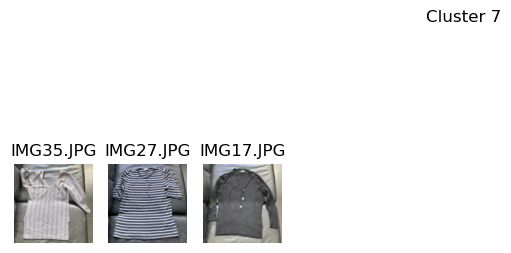

In [19]:
def show_images_by_cluster(cluster_num):
    idxs = np.where(labels == cluster_num)[0]
    plt.figure(figsize=(12, 4))
    for i, idx in enumerate(idxs[:10]):  # show first 10 images
        plt.subplot(1, 10, i+1)
        plt.imshow(X[idx])
        plt.axis('off')
        plt.title(f"{filenames[idx]}")
    plt.suptitle(f"Cluster {cluster_num}")
    plt.show()

for i in range(n_clusters):
    show_images_by_cluster(i)

In [21]:
image_extensions = ('.jpg', '.jpeg', '.png')  # Add other extensions if needed

image_paths = [os.path.join(image_dir, fname)
               for fname in os.listdir(image_dir)
               if fname.lower().endswith(image_extensions)]

In [27]:
import matplotlib.image as mpimg

def plot_clusters_grid(image_paths, cluster_labels, n_clusters):
    fig, axs = plt.subplots(n_clusters, 1, figsize=(15, 5 * n_clusters))

    for cluster_id in range(n_clusters):
        idxs = [i for i, label in enumerate(cluster_labels) if label == cluster_id]
        cluster_imgs = [image_paths[i] for i in idxs]

        n_cols = 5
        n_rows = (len(cluster_imgs) + n_cols - 1) // n_cols
        fig_cluster, axs_cluster = plt.subplots(n_rows, n_cols, figsize=(15, 3 * n_rows))

        fig_cluster.suptitle(f'Cluster {cluster_id}', fontsize=16)
        for i, img_path in enumerate(cluster_imgs):
            row, col = divmod(i, n_cols)
            ax = axs_cluster[row][col] if n_rows > 1 else axs_cluster[col]
            img = mpimg.imread(img_path)
            ax.imshow(img)
            ax.axis('off')

        # Hide extra subplots
        for j in range(i + 1, n_rows * n_cols):
            row, col = divmod(j, n_cols)
            ax = axs_cluster[row][col] if n_rows > 1 else axs_cluster[col]
            ax.axis('off')

        plt.tight_layout()
        plt.show()

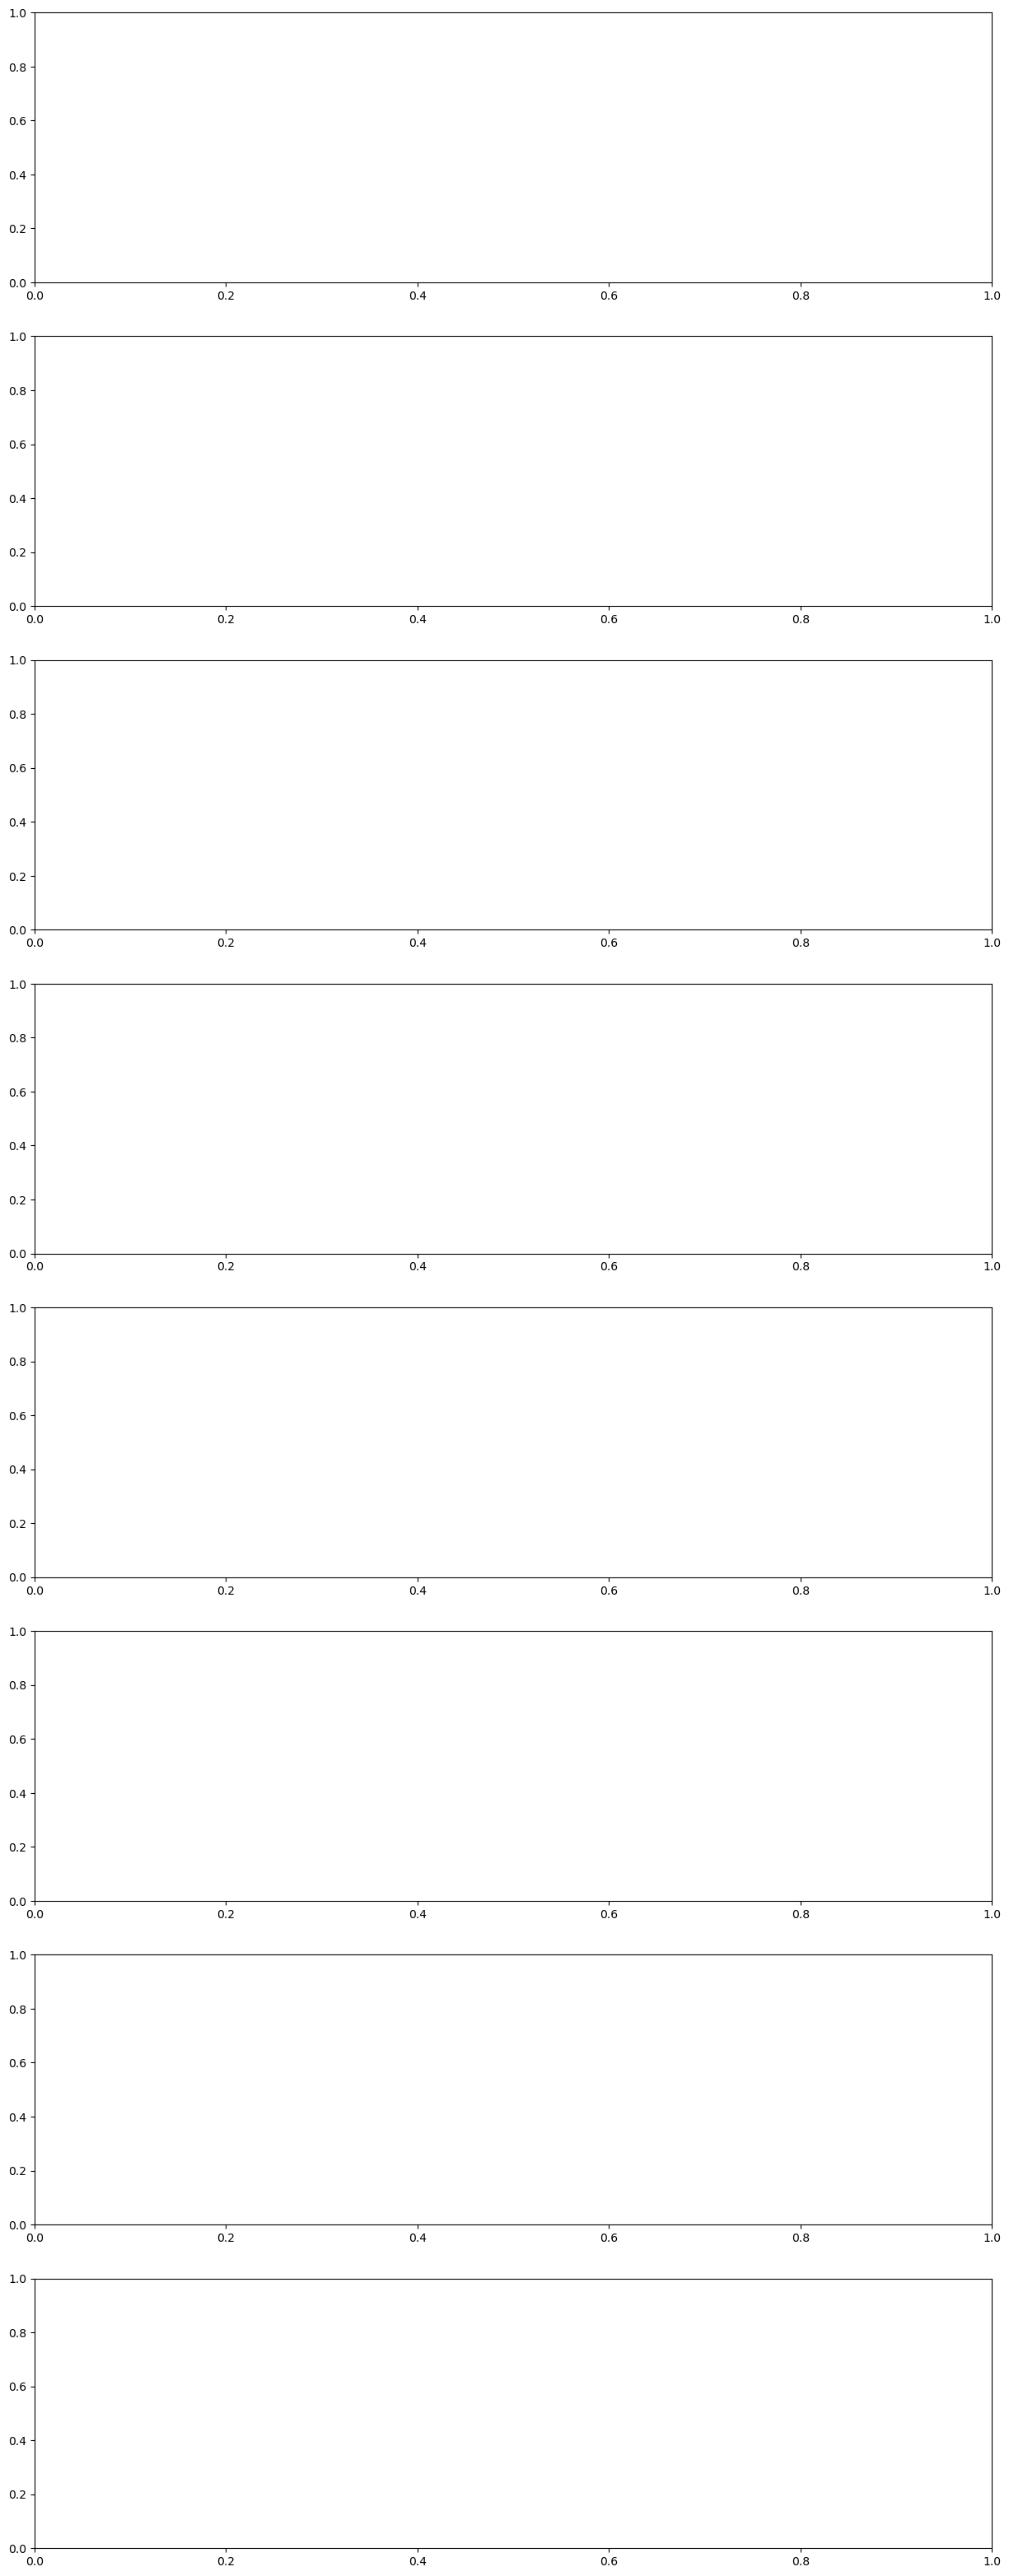

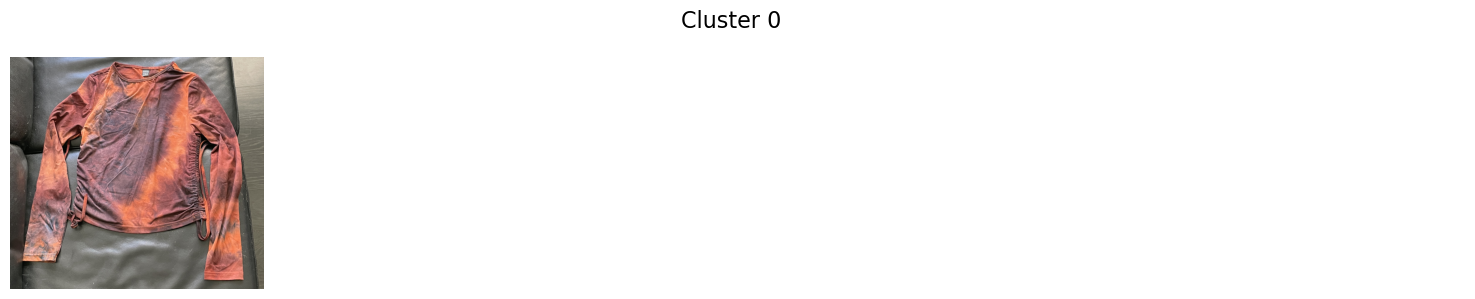

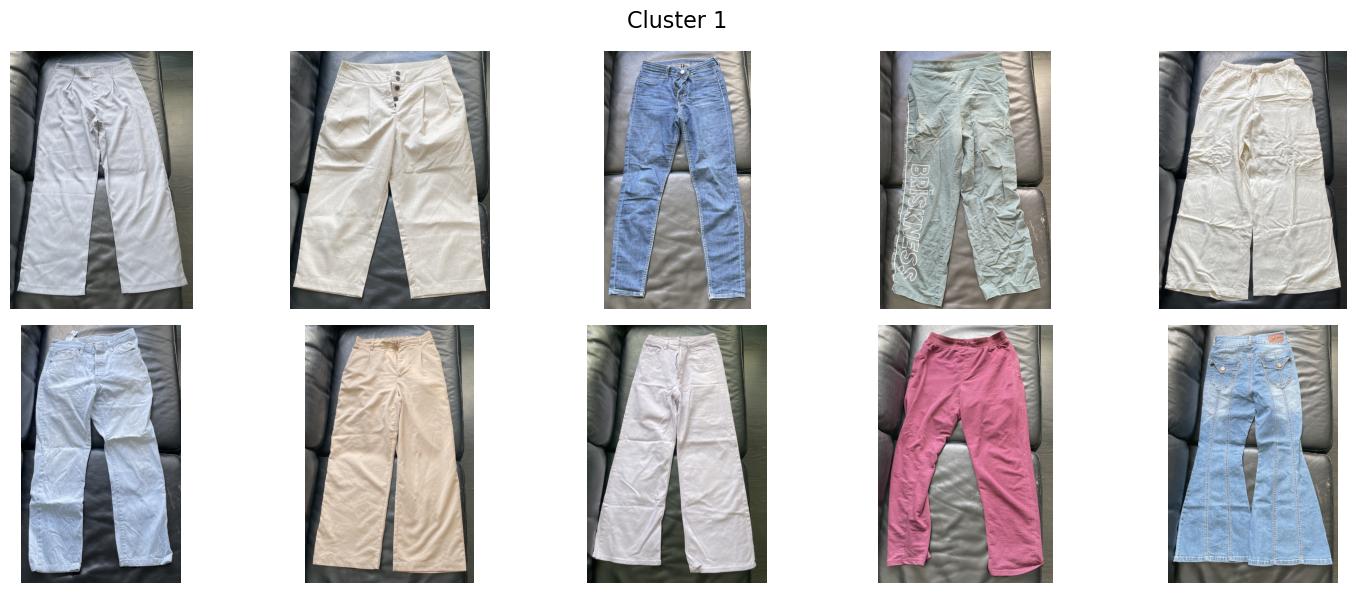

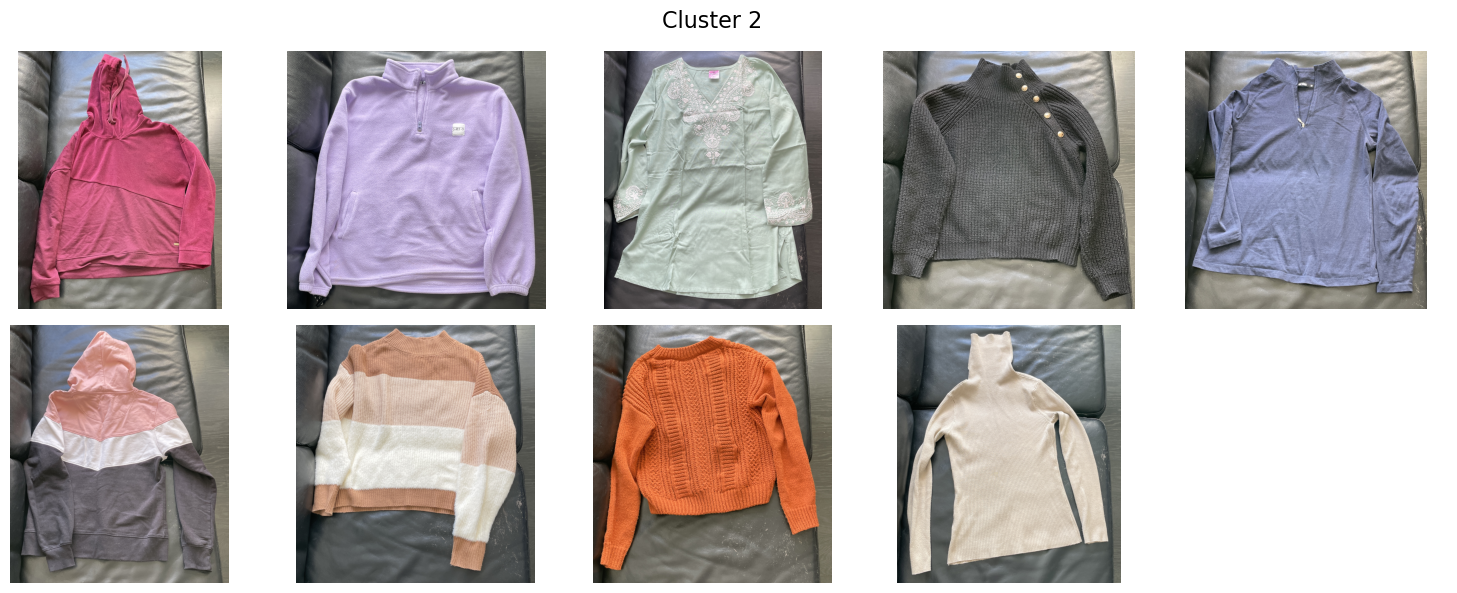

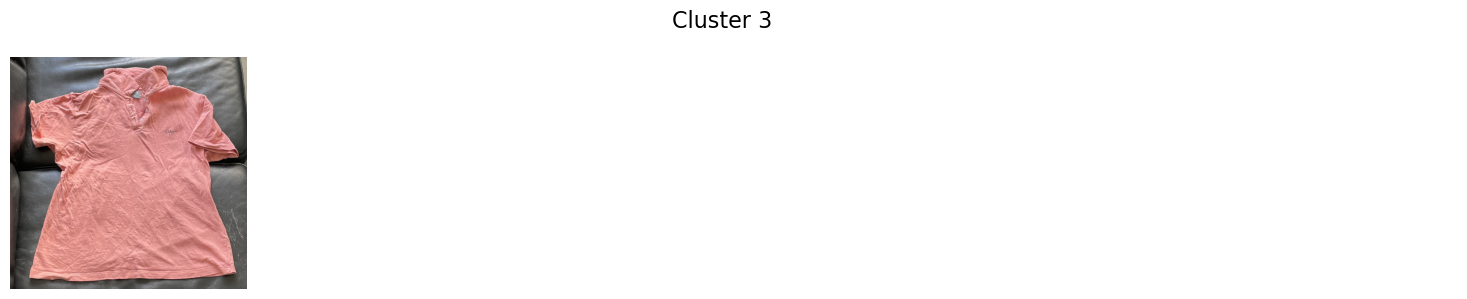

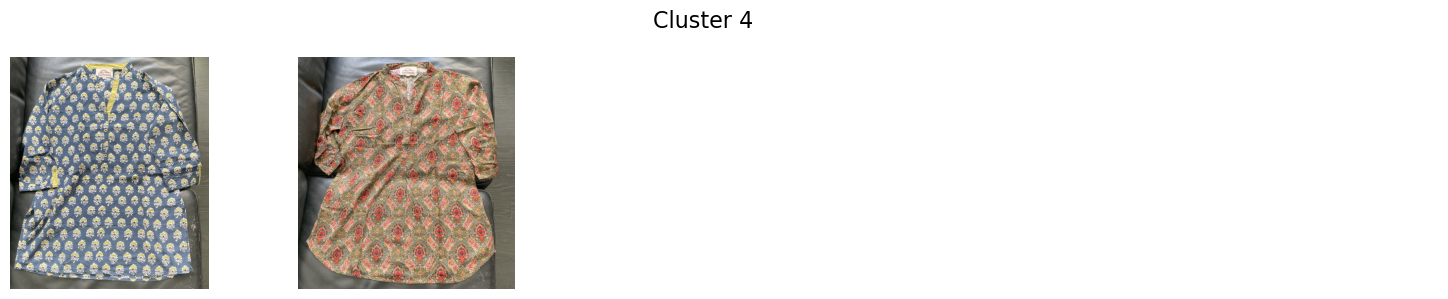

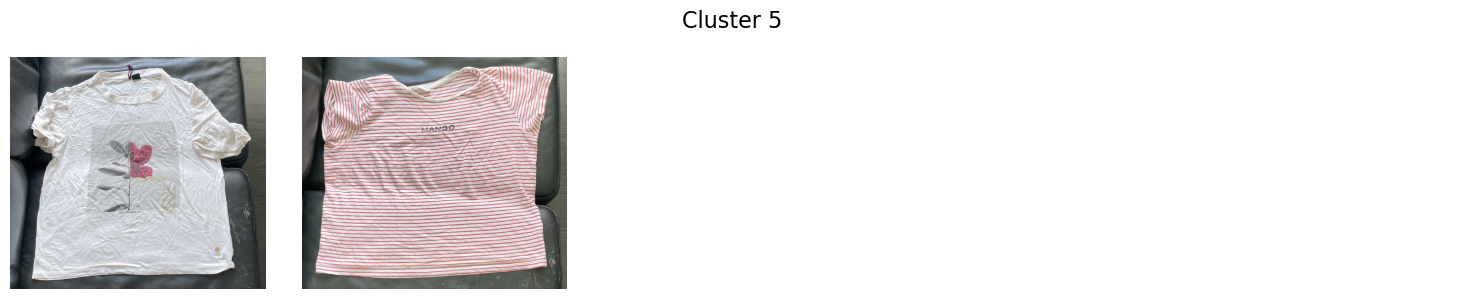

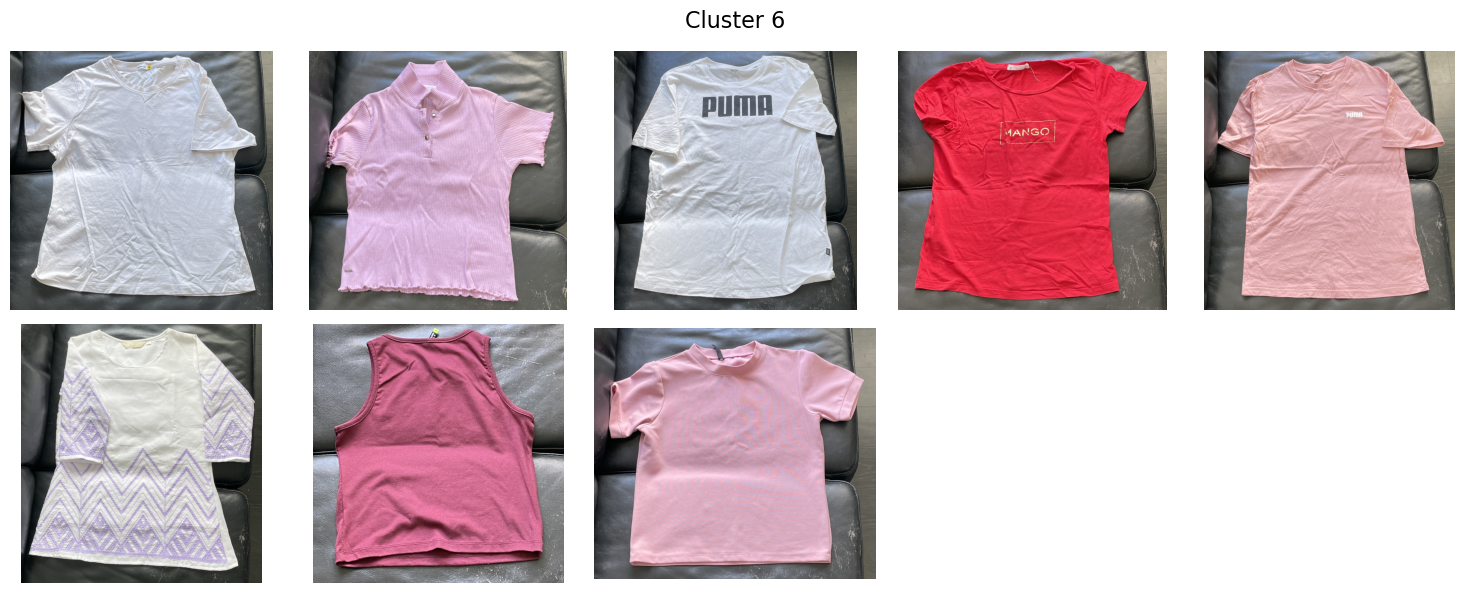

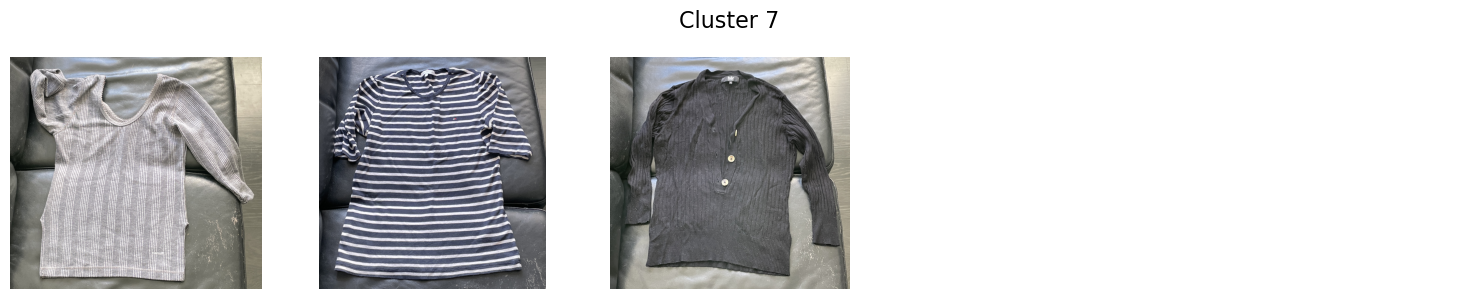

In [29]:
plot_clusters_grid(image_paths, labels, 8)